In [1]:
# Library Import
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import scipy.signal
from math import log, log10, exp, e, pow, sqrt
import numpy as np
from scipy import integrate
from datetime import datetime
import datetime
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
##################################Ridership data######################################

In [3]:
# Import trip data
trip_df = []
trip_file = os.listdir()
trip_filename = list(filter(lambda x:'bike_share_2020' in x or 'bike_share_2021' in x or 'bike_share_2022' in x, trip_file))

# Clean trip data (column name)
for filename in trip_filename:
    temp_df = pd.read_csv(filename)
    temp_df.columns = temp_df.columns.str.replace(' ', '_')
    temp_df.columns = temp_df.columns.str.title()
    temp_df = temp_df.rename(columns = {'Trip__Duration': 'Trip_Duration'})
    temp_df = temp_df.rename(columns = {'Ï»¿Trip_Id': 'Trip_Id'})
    trip_df.append(temp_df)

# Unify the datetime column of dataset, make the format the same and count the day only
trip_data = pd.concat(trip_df, ignore_index = True, axis = 0)
trip_data['Start_Time'] = trip_data['Start_Time'].str[:10]
trip_data['End_Time'] = trip_data['End_Time'].str[:10]
trip_data['Start_Time'] = pd.to_datetime(trip_data['Start_Time'], format = '%d/%m/%Y', utc = True)
trip_data['End_Time'] = pd.to_datetime(trip_data['End_Time'], format = '%d/%m/%Y', utc = True)
trip_data['Start_Time'] = trip_data['Start_Time'].dt.tz_convert(tz = 'EST')
trip_data['End_Time'] = trip_data['End_Time'].dt.tz_convert(tz = 'EST')
trip_data.drop(columns = ['Subscription_Id', 'Bike_Id'], inplace = True)
trip_data.head(5)

,Trip_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,User_Type
0,7334128,648,7003,2019-12-31 19:00:00-05:00,Madison Ave / Bloor St W,7271.0,2019-12-31 19:00:00-05:00,Yonge St / Alexander St - SMART,Annual Member
1,7334129,419,7007,2019-12-31 19:00:00-05:00,College St / Huron St,7163.0,2019-12-31 19:00:00-05:00,Yonge St / Wood St,Annual Member
2,7334130,566,7113,2019-12-31 19:00:00-05:00,Parliament St / Aberdeen Ave,7108.0,2019-12-31 19:00:00-05:00,Front St E / Cherry St,Annual Member
3,7334131,1274,7333,2019-12-31 19:00:00-05:00,King St E / Victoria St,7311.0,2019-12-31 19:00:00-05:00,Sherbourne St / Isabella St,Annual Member
4,7334132,906,7009,2019-12-31 19:00:00-05:00,King St E / Jarvis St,7004.0,2019-12-31 19:00:00-05:00,University Ave / Elm St,Casual Member


In [4]:
#Deal with outlier of trip duration 
trip_data = trip_data.drop(trip_data[trip_data['Trip_Duration'] < 60].index)

Q1 = trip_data['Trip_Duration'].quantile(0.25)
Q3 = trip_data['Trip_Duration'].quantile(0.75)
IQR = Q3 - Q1
const_1 = Q1 - 1.5*IQR
const_2 = Q3 + 1.5*IQR
trip_data = trip_data.drop(trip_data[(trip_data['Trip_Duration'] < const_1) | (trip_data['Trip_Duration'] > const_2)].index)

trip_data.head()

,Trip_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,User_Type
0,7334128,648,7003,2019-12-31 19:00:00-05:00,Madison Ave / Bloor St W,7271.0,2019-12-31 19:00:00-05:00,Yonge St / Alexander St - SMART,Annual Member
1,7334129,419,7007,2019-12-31 19:00:00-05:00,College St / Huron St,7163.0,2019-12-31 19:00:00-05:00,Yonge St / Wood St,Annual Member
2,7334130,566,7113,2019-12-31 19:00:00-05:00,Parliament St / Aberdeen Ave,7108.0,2019-12-31 19:00:00-05:00,Front St E / Cherry St,Annual Member
3,7334131,1274,7333,2019-12-31 19:00:00-05:00,King St E / Victoria St,7311.0,2019-12-31 19:00:00-05:00,Sherbourne St / Isabella St,Annual Member
4,7334132,906,7009,2019-12-31 19:00:00-05:00,King St E / Jarvis St,7004.0,2019-12-31 19:00:00-05:00,University Ave / Elm St,Casual Member


In [5]:
#Drop station information since it is less correlative to covid influence on trip data 
trip_data = trip_data.drop_duplicates(subset=['Trip_Id'])
trip_data = trip_data.drop(columns = ['Trip_Id', 'Trip_Duration',
                            'Start_Station_Id', 'Start_Station_Name',
                            'End_Station_Id', 'End_Station_Name'])
print(trip_data.isnull().sum())
trip_data = trip_data.dropna()

Start_Time    0
End_Time      0
User_Type     0
dtype: int64


In [258]:
###############################Weather data##################################

In [259]:
#Import weather data
import time
weather_df = []
weather_file = os.listdir()
weather_filename = list(filter(lambda x: '6158359' in x, weather_file))

for filename in weather_filename:
    temp_weather_df = pd.read_csv(filename)
    
    if 'Date/Time' in temp_weather_df.columns:
        temp_weather_df = temp_weather_df.rename(columns = {'Date/Time': 'weather_date'})
        temp_weather_df['weather_date'] = pd.to_datetime(temp_weather_df['weather_date'])
        temp_weather_df = temp_weather_df.set_index(temp_weather_df['weather_date'])
    
    else:
        temp_weather_df = temp_weather_df.rename(columns = {'Date/Time (LST)': 'weather_date'})
        temp_weather_df['weather_date'] = pd.to_datetime(temp_weather_df['weather_date'])
        temp_weather_df = temp_weather_df.set_index(temp_weather_df['weather_date'])

    weather_df.append(temp_weather_df)

weather_data = pd.concat(weather_df)
weather_data.drop(columns = ['weather_date'])
weather_data.index = weather_data.index.tz_localize(tz = 'EST')
weather_data.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,weather_date,Year,Month,Day,Time (LST),Temp (°C),...,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Time
weather_date,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 00:00:00,2021,11,1,00:00,9.3,...,16.1,NaN,100.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01 01:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 01:00:00,2021,11,1,01:00,8.5,...,16.1,NaN,100.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01 02:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 02:00:00,2021,11,1,02:00,8.0,...,16.1,NaN,100.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01 03:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 03:00:00,2021,11,1,03:00,7.7,...,16.1,NaN,100.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01 04:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 04:00:00,2021,11,1,04:00,7.0,...,16.1,NaN,100.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [260]:
#Drop none-numerical columns, location columns, and date information
weather_data = weather_data.drop(columns = ['Longitude (x)', 'Latitude (y)',
                             'Year', 'Month', 'Day', 'Time (LST)', 'Time',
                            'Station Name', 'Climate ID',
                            'Temp Flag', 'Dew Point Temp Flag', 'Rel Hum Flag', 'Precip. Amount Flag', 'Wind Dir Flag', 'Wind Spd Flag', 'Visibility Flag', 'Stn Press Flag', 'Hmdx Flag', 'Wind Chill Flag'])

In [261]:
#############Weather abd ridership data merge#####################

In [262]:
#Merge weather and trip on hour
weather_data['Merge_Time'] = weather_data.index
trip_data['Merge_Time'] = trip_data['Start_Time'].dt.floor('H')
data_merged = pd.merge(trip_data, weather_data, on = 'Merge_Time')
data_merged = data_merged.drop(columns = ['Start_Time', 'End_Time', 'weather_date'])
data_merged.head()

,User_Type,Merge_Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,Casual Member,2022-06-30 19:00:00-05:00,19.2,16.3,83.0,0.0,8.0,5.0,16.1,100.65,NaN,NaN,NaN
1,Casual Member,2022-06-30 19:00:00-05:00,19.2,16.3,83.0,0.0,8.0,5.0,16.1,100.65,NaN,NaN,NaN
2,Annual Member,2022-06-30 19:00:00-05:00,19.2,16.3,83.0,0.0,8.0,5.0,16.1,100.65,NaN,NaN,NaN
3,Annual Member,2022-06-30 19:00:00-05:00,19.2,16.3,83.0,0.0,8.0,5.0,16.1,100.65,NaN,NaN,NaN
4,Casual Member,2022-06-30 19:00:00-05:00,19.2,16.3,83.0,0.0,8.0,5.0,16.1,100.65,NaN,NaN,NaN


In [263]:
#Convert hourly data to daily data using aggergate function
data_merged['Merge_Day'] = data_merged['Merge_Time'].dt.floor('D')
data_days = data_merged.groupby('Merge_Day').agg(
    rides = pd.NamedAgg(column = 'Merge_Day', aggfunc = 'count'),
    annual_members = pd.NamedAgg(column = 'User_Type', aggfunc = lambda x: x[x == 'Annual Member'].count()),
    casual_members = pd.NamedAgg(column = 'User_Type', aggfunc = lambda x: x[x == 'Casual Member'].count()),
    workday = pd.NamedAgg(column = 'Merge_Day', aggfunc = lambda x: pd.to_datetime(x, format='%Y-%m-%d %h:%m:%s-%h:%m').dt.day_of_week.max()<5),
    temp = pd.NamedAgg(column = 'Temp (°C)', aggfunc = 'mean'),
    dew_temp = pd.NamedAgg(column = 'Dew Point Temp (°C)', aggfunc = 'mean'),
    rh = pd.NamedAgg(column = 'Rel Hum (%)', aggfunc = 'mean'),
    prec = pd.NamedAgg(column = 'Precip. Amount (mm)', aggfunc = 'mean'),
    wind_dir = pd.NamedAgg(column = 'Wind Dir (10s deg)', aggfunc = 'mean'),
    wind_speed = pd.NamedAgg(column = 'Wind Spd (km/h)', aggfunc = 'mean'),
    visibility = pd.NamedAgg(column = 'Visibility (km)', aggfunc = 'mean'),
    press = pd.NamedAgg(column = 'Stn Press (kPa)', aggfunc = 'mean'),
    hmdx = pd.NamedAgg(column = 'Hmdx', aggfunc = 'mean'),
    wind_chill = pd.NamedAgg(column = 'Wind Chill', aggfunc = 'mean'),
    weather = pd.NamedAgg(column = 'Weather', aggfunc = lambda x: 'clear' if x.isnull().mean() >=0.5 else 'Percipitation')
).reset_index().rename(columns={'Merge_Day': 'Start_Time'}).set_index('Start_Time', drop=True)
data_days.head()

,rides,annual_members,casual_members,workday,temp,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather
Start_Time,,,,,,,,,,,,,,,
2019-12-31 00:00:00-05:00,1329,1107,222,True,0.7,-3.7,72.0,NaN,25.0,39.0,16.1,99.18,NaN,NaN,clear
2020-01-01 00:00:00-05:00,3718,3437,281,True,-0.5,-4.9,72.0,NaN,23.0,28.0,16.1,99.93,NaN,-7.0,clear
2020-01-02 00:00:00-05:00,4351,3955,396,True,4.1,1.6,84.0,NaN,25.0,11.0,16.1,99.61,NaN,NaN,clear
2020-01-03 00:00:00-05:00,2367,2171,196,True,6.0,-0.4,64.0,NaN,29.0,11.0,16.1,100.07,NaN,NaN,clear
2020-01-04 00:00:00-05:00,1951,1823,128,False,1.9,-2.5,73.0,NaN,28.0,21.0,16.1,99.98,NaN,NaN,clear


In [264]:
#Deal with date time column
date_list = []
data_days = data_days.reset_index()
for date in data_days['Start_Time']:
    date = date.date()
    date_list.append(date)
data_days['date'] = date_list
data_days = data_days.drop('Start_Time',axis = 1)
data_days.head()

,rides,annual_members,casual_members,workday,temp,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather,date
0,1329,1107,222,True,0.7,-3.7,72.0,NaN,25.0,39.0,16.1,99.18,NaN,NaN,clear,2019-12-31
1,3718,3437,281,True,-0.5,-4.9,72.0,NaN,23.0,28.0,16.1,99.93,NaN,-7.0,clear,2020-01-01
2,4351,3955,396,True,4.1,1.6,84.0,NaN,25.0,11.0,16.1,99.61,NaN,NaN,clear,2020-01-02
3,2367,2171,196,True,6.0,-0.4,64.0,NaN,29.0,11.0,16.1,100.07,NaN,NaN,clear,2020-01-03
4,1951,1823,128,False,1.9,-2.5,73.0,NaN,28.0,21.0,16.1,99.98,NaN,NaN,clear,2020-01-04


In [265]:
#Drop data before 2020-02-04
data_days_after_20200204 = data_days[(data_days['date']>= datetime.date(2020, 2, 4))]
data_days_after_20200204.head()

,rides,annual_members,casual_members,workday,temp,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather,date
35,4694,4525,169,True,1.2,-5.1,63.0,NaN,34.0,18.0,16.1,100.60,NaN,NaN,clear,2020-02-04
36,2055,1917,138,True,-3.5,-10.3,60.0,NaN,7.0,13.0,16.1,100.89,NaN,-8.0,clear,2020-02-05
37,1815,1727,88,True,-3.3,-6.8,77.0,NaN,5.0,18.0,14.5,99.08,NaN,-9.0,clear,2020-02-06
38,1540,1339,201,True,-5.3,-12.3,58.0,NaN,29.0,24.0,16.1,99.62,NaN,-13.0,clear,2020-02-07
39,1564,1394,170,False,-7.5,-12.4,68.0,NaN,11.0,8.0,16.1,101.71,NaN,-12.0,clear,2020-02-08


In [266]:
####################################COVID data#####################################

In [267]:
from datetime import datetime
covid_df = []
covid_file = os.listdir()
covid_filename = list(filter(lambda x:'data_download' in x, covid_file))

for filename in covid_filename:
    temp_df = pd.read_csv(filename)
    temp_df = temp_df[temp_df['location_name'] == 'Canada']
    covid_df.append(temp_df)

covid_data = pd.concat(covid_df, ignore_index = True, axis = 0)

# convert string to datetime date
datetime_list = []
for time in covid_data['date']:
    format = '%Y/%m/%d'
    datetime_time = datetime.strptime(time.replace('-','/'),format).date()
    datetime_list.append(datetime_time)
covid_data['date'] = datetime_list

In [268]:
# Check nan values
nanlist = covid_data.isna().sum()!=0 
nan_column = pd.DataFrame()
nan_column['nan'] = nanlist
nan_column[nan_column['nan'] == True].index

Index(['reff_mean', 'reff_lower', 'reff_upper', 'cumulative_deaths',
       'daily_deaths', 'cumulative_cases', 'cumulative_hospitalizations',
       'cumulative_deaths_unscaled', 'daily_deaths_unscaled', 'daily_cases',
       'cumulative_all_vaccinated', 'cumulative_all_fully_vaccinated',
       'cumulative_all_effectively_vaccinated'],
      dtype='object')

In [269]:
# fill nan with meanvalues
for nacolumns in nan_column[nan_column['nan'] == True].index:
    covid_data[nacolumns] = covid_data[nacolumns].fillna(covid_data[nacolumns].mean())
covid_data

# Drop all nan columns
covid_data = covid_data.drop(['reff_mean', 'reff_lower', 'reff_upper','infection_fatality', 'location_id', 'version_name', 'location_name'],axis = 1)

In [270]:
#Drop the colomns that describe the same feature
covid_data = covid_data.drop(covid_data.filter(regex='upper|lower').columns, axis=1)

Now the data is cleaned with only numerical values

In [271]:
covid_data.columns

Index(['date', 'inf_mean', 'seir_cumulative_mean', 'inf_cuml_mean',
       'seir_daily_mean', 'seir_daily_unscaled_mean',
       'seir_cumulative_unscaled_mean', 'cases_mean', 'inf_cuml_mean_vax',
       'inf_cuml_mean_unvax', 'inf_mean_vax', 'inf_mean_unvax',
       'cumulative_deaths', 'daily_deaths', 'cumulative_cases',
       'cumulative_hospitalizations', 'cumulative_deaths_unscaled',
       'daily_deaths_unscaled', 'daily_cases', 'population', 'pneumonia_mean',
       'pneumonia_obs', 'mask_use_mean', 'mask_use_obs',
       'cumulative_all_vaccinated', 'cumulative_all_fully_vaccinated',
       'cumulative_all_effectively_vaccinated', 'hospital_beds_mean',
       'icu_beds_mean', 'admis_mean', 'admis_mean_vax', 'admis_mean_unvax',
       'all_bed_capacity', 'icu_bed_capacity', 'infection_detection',
       'infection_hospitalization'],
      dtype='object')

In [272]:
import datetime
covid_data_before_20220830 = covid_data[(covid_data['date']<= datetime.date(2022, 8, 30))]
covid_data_after_20220830 = covid_data[(covid_data['date']>= datetime.date(2022, 8, 30))]

In [273]:
covid_data_before_20220830.head()

,date,inf_mean,seir_cumulative_mean,inf_cuml_mean,seir_daily_mean,seir_daily_unscaled_mean,seir_cumulative_unscaled_mean,cases_mean,inf_cuml_mean_vax,inf_cuml_mean_unvax,...,cumulative_all_effectively_vaccinated,hospital_beds_mean,icu_beds_mean,admis_mean,admis_mean_vax,admis_mean_unvax,all_bed_capacity,icu_bed_capacity,infection_detection,infection_hospitalization
0,2020-02-04,34.34,0.06,785.82,0.06,0.04,0.04,0.69,0.0,785.821621,...,2.107624e+07,6.72,2.70,0.94,0.0,0.942791,86460.0,4048.0,0.0262,0.0337
1,2020-02-05,34.58,0.12,820.40,0.06,0.04,0.08,0.44,0.0,820.399018,...,2.107624e+07,7.31,2.93,0.76,0.0,0.756101,86460.0,4048.0,0.0144,0.0245
2,2020-02-06,35.73,0.18,856.13,0.06,0.04,0.11,0.42,0.0,856.127264,...,2.107624e+07,7.82,3.14,0.71,0.0,0.705766,86460.0,4048.0,0.0120,0.0198
3,2020-02-07,38.24,0.24,894.37,0.06,0.04,0.15,0.38,0.0,894.370921,...,2.107624e+07,8.33,3.34,0.70,0.0,0.702697,86460.0,4048.0,0.0096,0.0173
4,2020-02-08,40.35,0.30,934.72,0.06,0.04,0.19,0.35,0.0,934.722098,...,2.107624e+07,8.82,3.54,0.70,0.0,0.695029,86460.0,4048.0,0.0087,0.0171


<AxesSubplot:>

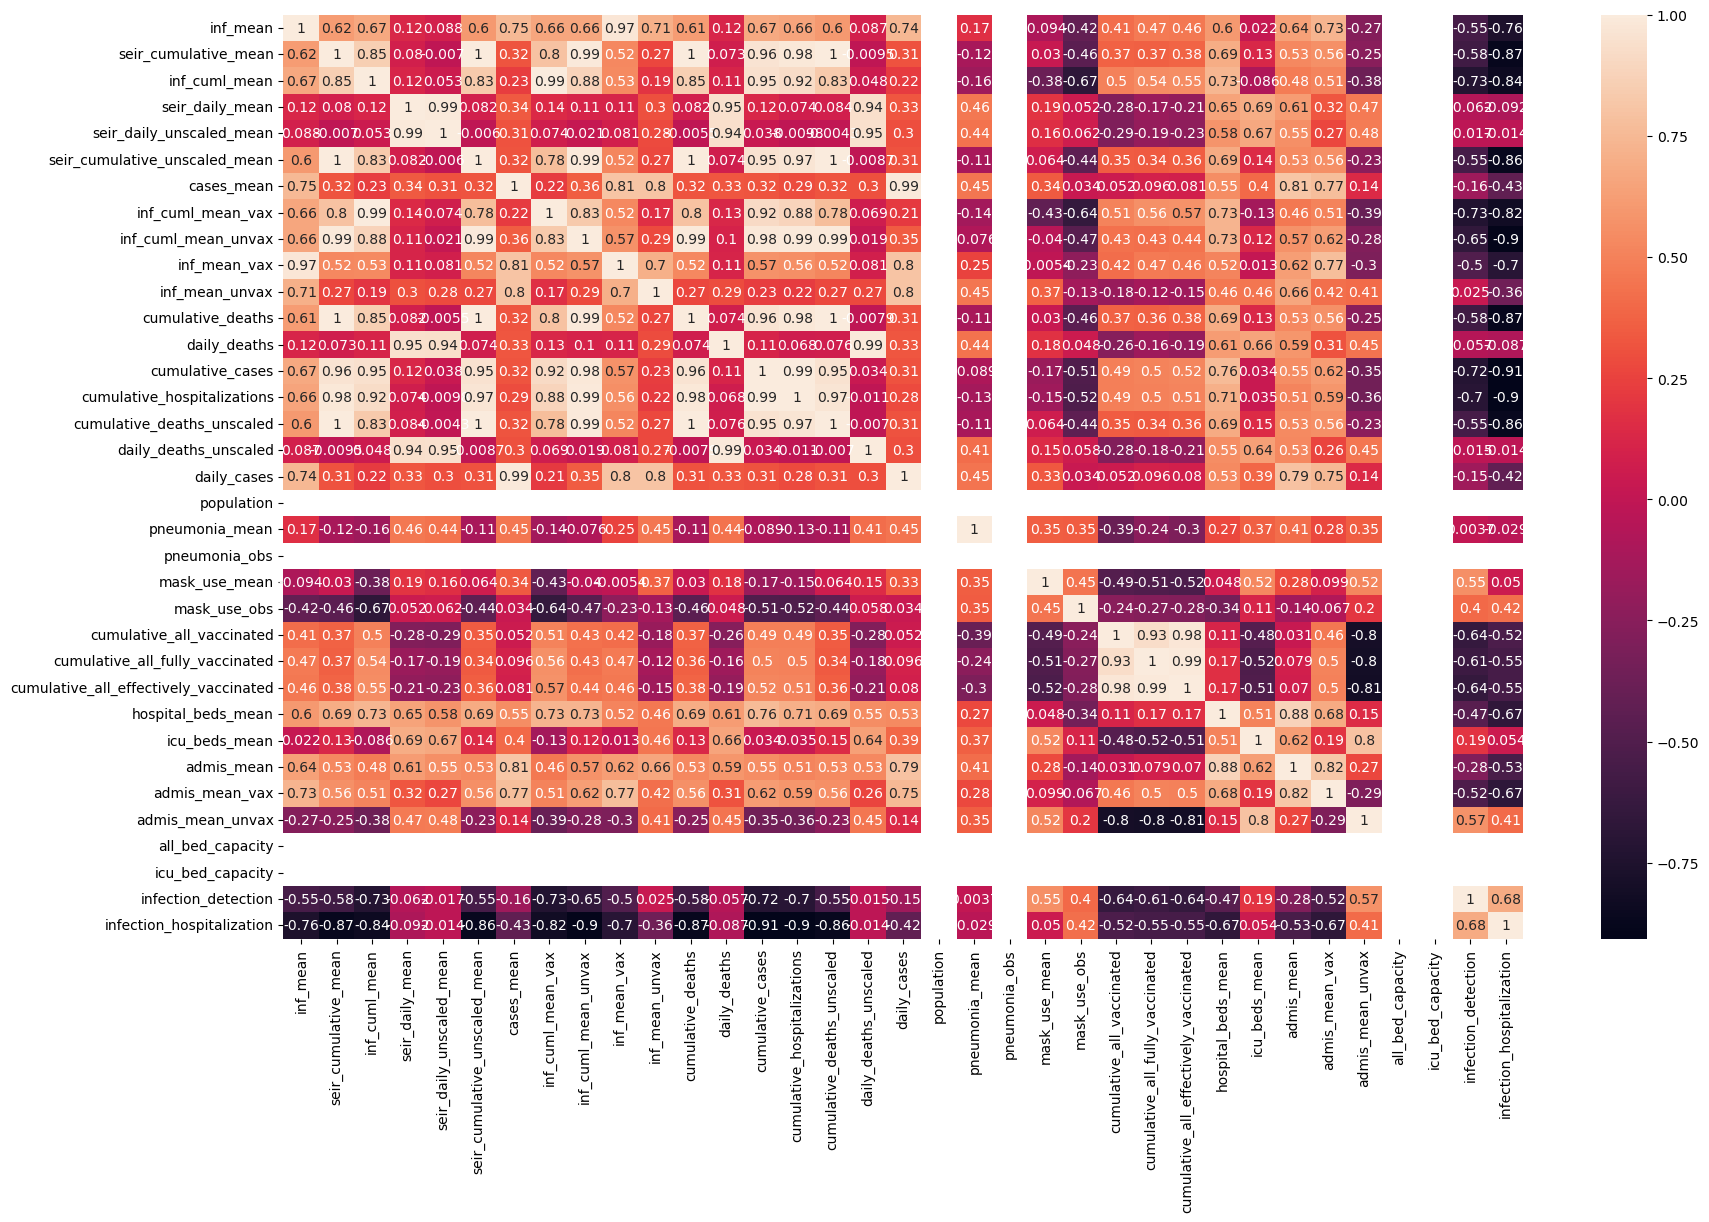

In [274]:
cor = covid_data_before_20220830.corr()
import seaborn as sns
plt.figure(figsize = (20, 12))
sns.heatmap(cor, annot = True)

In [275]:
####################################Combineddata############################################

In [276]:
merged_final = covid_data_before_20220830.merge(data_days_after_20200204, left_on='date',right_on='date')

In [277]:
# Check nan values
nanlist = merged_final.isna().sum()!=0 
nan_column = pd.DataFrame()
nan_column['nan'] = nanlist
nan_column[nan_column['nan'] == True].index

# fill nan with meanvalues
for nacolumns in nan_column[nan_column['nan'] == True].index:
    merged_final[nacolumns] = merged_final[nacolumns].fillna(merged_final[nacolumns].mean())


# # Drop all nan columns
# covid_data = covid_data.drop(['reff_mean', 'reff_lower', 'reff_upper','infection_fatality'],axis = 1)

In [278]:
merged_final = merged_final.drop(columns = ['rides'])
merged_final.head()

,date,inf_mean,seir_cumulative_mean,inf_cuml_mean,seir_daily_mean,seir_daily_unscaled_mean,seir_cumulative_unscaled_mean,cases_mean,inf_cuml_mean_vax,inf_cuml_mean_unvax,...,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather
0,2020-02-04,34.34,0.06,785.82,0.06,0.04,0.04,0.69,0.0,785.821621,...,-5.1,63.0,0.073981,34.0,18.0,16.1,100.60,29.744681,-10.992366,clear
1,2020-02-05,34.58,0.12,820.40,0.06,0.04,0.08,0.44,0.0,820.399018,...,-10.3,60.0,0.073981,7.0,13.0,16.1,100.89,29.744681,-8.000000,clear
2,2020-02-06,35.73,0.18,856.13,0.06,0.04,0.11,0.42,0.0,856.127264,...,-6.8,77.0,0.073981,5.0,18.0,14.5,99.08,29.744681,-9.000000,clear
3,2020-02-07,38.24,0.24,894.37,0.06,0.04,0.15,0.38,0.0,894.370921,...,-12.3,58.0,0.073981,29.0,24.0,16.1,99.62,29.744681,-13.000000,clear
4,2020-02-08,40.35,0.30,934.72,0.06,0.04,0.19,0.35,0.0,934.722098,...,-12.4,68.0,0.073981,11.0,8.0,16.1,101.71,29.744681,-12.000000,clear


In [279]:
merged_final.columns

Index(['date', 'inf_mean', 'seir_cumulative_mean', 'inf_cuml_mean',
       'seir_daily_mean', 'seir_daily_unscaled_mean',
       'seir_cumulative_unscaled_mean', 'cases_mean', 'inf_cuml_mean_vax',
       'inf_cuml_mean_unvax', 'inf_mean_vax', 'inf_mean_unvax',
       'cumulative_deaths', 'daily_deaths', 'cumulative_cases',
       'cumulative_hospitalizations', 'cumulative_deaths_unscaled',
       'daily_deaths_unscaled', 'daily_cases', 'population', 'pneumonia_mean',
       'pneumonia_obs', 'mask_use_mean', 'mask_use_obs',
       'cumulative_all_vaccinated', 'cumulative_all_fully_vaccinated',
       'cumulative_all_effectively_vaccinated', 'hospital_beds_mean',
       'icu_beds_mean', 'admis_mean', 'admis_mean_vax', 'admis_mean_unvax',
       'all_bed_capacity', 'icu_bed_capacity', 'infection_detection',
       'infection_hospitalization', 'annual_members', 'casual_members',
       'workday', 'temp', 'dew_temp', 'rh', 'prec', 'wind_dir', 'wind_speed',
       'visibility', 'press', 'hmd

In [280]:
merged_final[['annual_members', 'casual_members']]

,annual_members,casual_members
0,4525,169
1,1917,138
2,1727,88
3,1339,201
4,1394,170
...,...,...
934,8685,18061
935,7779,16446
936,8713,11636
937,7918,9940


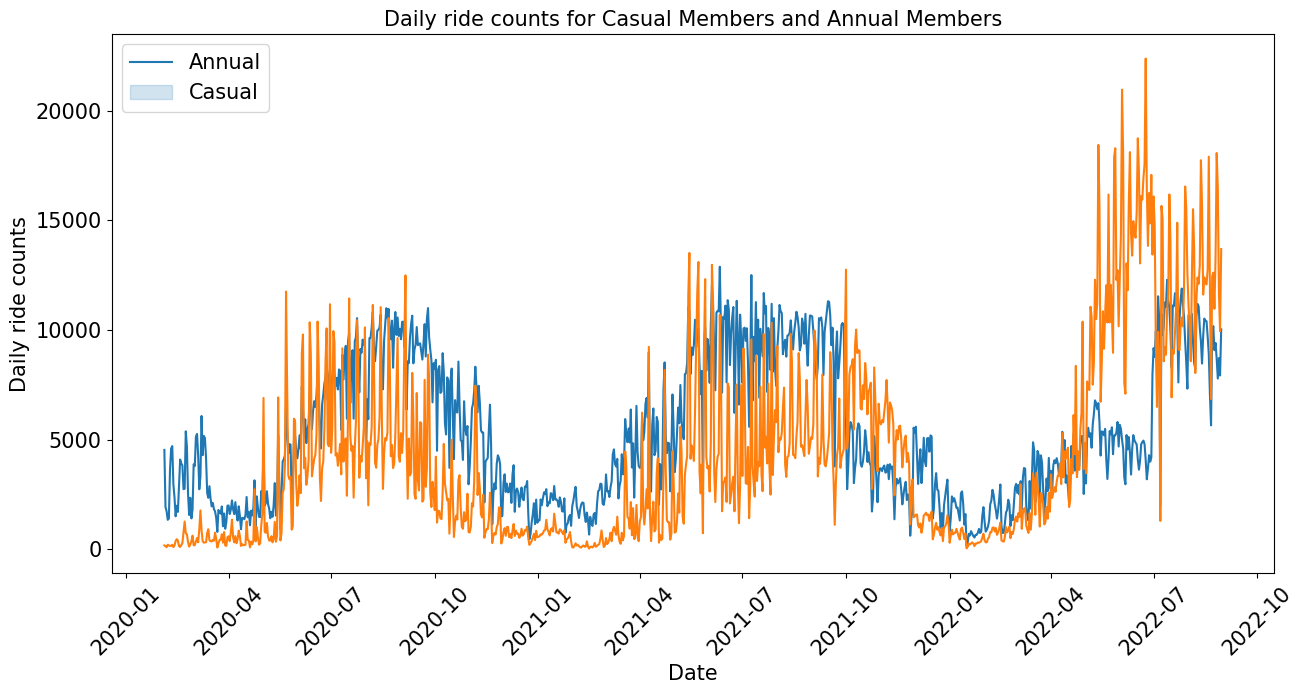

In [281]:
plt.figure(figsize = (15, 7))

sns.lineplot(data = merged_final, x = 'date', y ='annual_members' )
sns.lineplot(data = merged_final, x = 'date', y ='casual_members' )

# set plot title, labels, and legends
plt.title('Daily ride counts for Casual Members and Annual Members', fontsize = 15)
plt.ylabel('Daily ride counts', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels = ['Annual', 'Casual'], fontsize = 15)

In [282]:
#Convert categorical feature to numerical
merged_final = pd.get_dummies(merged_final, columns = ['weather', 'workday'], drop_first = True)

In [283]:
cat_label = ['weather_clear', 'workday_True']
int_label = ['pneumonia_obs', 'mask_use_obs']
merged_final[cat_label] = merged_final[cat_label].astype('category')
merged_final[int_label] = merged_final[int_label].astype('float')

In [284]:
######################Annual member########################

In [285]:
#############################Train test split for annual member###################

In [286]:
import datetime as dt
merged_annual = merged_final.drop(columns = ['casual_members'])
merged_annual['date'] = pd.to_datetime(merged_annual['date'])
merged_annual['date'] = merged_annual['date'].map(dt.datetime.toordinal)
merged_annual['date'] = merged_annual['date'].astype('float')

In [287]:
y_annual = pd.DataFrame(merged_annual['annual_members'].to_list(), 
                        index = merged_annual.index,
                        columns = ['num_annual'])
X_annual = merged_annual.drop(columns = ['annual_members'])

In [288]:
X_train_annual, X_test_val_annual, y_train_annual, y_test_val_annual = train_test_split(X_annual, y_annual, test_size = 0.3, random_state = 666)
X_test_annual, X_val_annual, y_test_annual, y_val_annual = train_test_split(X_test_val_annual, y_test_val_annual, test_size = 0.7, random_state = 333)

In [289]:
print(len(X_train_annual))
print(len(X_val_annual))
print(len(X_test_annual))

657
198
84


In [290]:
#################Feature Selection for annual member data#################

In [291]:
targets_annual = X_train_annual.columns

In [292]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude=['category'])),
        ('cat', OrdinalEncoder(), selector(dtype_include=['category']))],
        remainder='drop')
clf = RandomForestClassifier(random_state = 999, class_weight = 'balanced')
pipeline = Pipeline([('prep', column_trans),
                     ('clf', clf)])

pipeline.fit(X_train_annual, y_train_annual)
pipeline['clf'].feature_importances_

feat_list = []

In [293]:
total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets_annual, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets_annual, pipeline['clf'].feature_importances_):
    if feature[1] > .026:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))


 Cumulative Importance = 1.0
Most Important Features:
['inf_mean', 'seir_daily_mean', 'seir_daily_unscaled_mean', 'cases_mean', 'inf_mean_unvax', 'daily_deaths', 'daily_deaths_unscaled', 'daily_cases', 'pneumonia_mean', 'mask_use_mean', 'hospital_beds_mean', 'icu_beds_mean', 'admis_mean', 'admis_mean_unvax', 'infection_detection', 'infection_hospitalization', 'temp', 'dew_temp', 'rh', 'wind_dir', 'wind_speed', 'press']
Number of Included Features = 22


In [294]:
selected_fea_annual = included_feats

In [295]:
#Model 1: linear regression
linear_model_annual = LinearRegression(fit_intercept = True)

In [296]:
linear_model_annual.fit(X_train_annual[selected_fea_annual], y_train_annual)
y_fitted_annual = linear_model_annual.predict(X_train_annual[selected_fea_annual])
y_predicted_annual = linear_model_annual.predict(X_val_annual[selected_fea_annual])

In [297]:
linear_model_annual.coef_

array([[-9.64928537e-04, -2.13582702e+01,  7.72607458e+00,
         8.67297625e-02, -2.62274133e-02, -6.30544988e+00,
         1.10478922e+01, -8.98886036e-02, -1.25669727e+04,
         3.06729923e+03, -9.29979350e-02, -2.29672906e+00,
         3.92098334e+00,  1.31091986e+01, -3.35839702e+03,
        -4.49817282e+04,  9.08422869e+01, -2.81515383e+01,
         1.06500088e+01,  1.15678629e+01, -5.79639343e+00,
         2.61244754e+02]])

In [298]:
linear_model_annual.intercept_

array([-10428.64829489])

In [299]:
def rmse(actual, predicted):
    se = (actual - predicted)**2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    
    return rmse    

In [300]:
training_error_annual = rmse(y_train_annual, y_fitted_annual)
training_mae_annual = mean_absolute_error(y_train_annual, y_fitted_annual)
r2_score_training_annual = r2_score(y_train_annual, y_fitted_annual)

print('Training RMSE: {}'.format(training_error_annual))
print('Training MAE: {}'.format(training_mae_annual))
print('Training R2 score: {}'.format(r2_score_training_annual))

Training RMSE: num_annual    1546.626589
dtype: float64
Training MAE: 1195.206626550537
Training R2 score: 0.7700194371232975


In [301]:
val_error_annual = rmse(y_val_annual, y_predicted_annual)
val_mae_annual = mean_absolute_error(y_val_annual, y_predicted_annual)
r2_score_val_annual = r2_score(y_val_annual, y_predicted_annual)
print('Validation RMSE: {}'.format(val_error_annual))
print('Validation MAE: {}'.format(val_mae_annual))
print('Validation R2 score: {}'.format(r2_score_val_annual))

Validation RMSE: num_annual    1656.411986
dtype: float64
Validation MAE: 1300.7663611928774
Validation R2 score: 0.7228000916301291


In [302]:
# Prediction on test set
y_pred_test_annual = linear_model_annual.predict(X_test_annual[selected_fea_annual])

test_error_annual = rmse(y_test_annual, y_pred_test_annual)
test_mae_annual = mean_absolute_error(y_test_annual, y_pred_test_annual)
r2_score_test_annual = r2_score(y_test_annual, y_pred_test_annual)

print('Test RMSE: {}'.format(test_error_annual))
print('Test MAE: {}'.format(test_mae_annual))
print('Test R2 score: {}'.format(r2_score_test_annual))

Test RMSE: num_annual    1579.492312
dtype: float64
Test MAE: 1212.0971566965766
Test R2 score: 0.7888992880278902


In [303]:
x_axis_annual = np.arange(len(y_test_annual))
annual_data = pd.concat([pd.DataFrame(x_axis_annual), y_test_annual.reset_index(), pd.DataFrame(y_pred_test_annual)],axis =1, ignore_index = True)
annual_data.columns = ['x_axis', 'index', 'true', 'predicted']

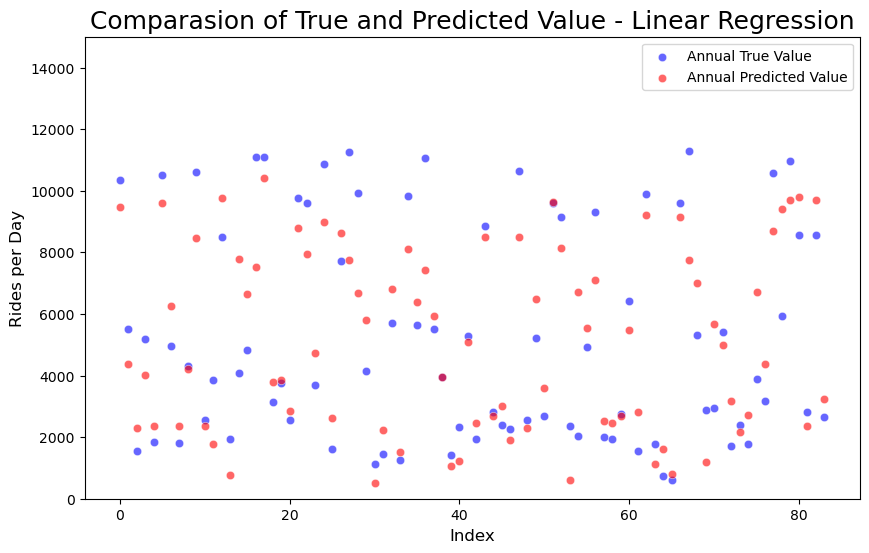

In [304]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = annual_data, x = 'x_axis', y = 'true', color = 'b', label = 'Annual True Value', alpha = 0.6)
sns.scatterplot(data = annual_data, x = 'x_axis', y = 'predicted', color = 'r', label = 'Annual Predicted Value', alpha = 0.6)
plt.ylim([0,15000])
plt.title('Comparasion of True and Predicted Value - Linear Regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [305]:
######################Cross Validation for annual member######################

In [306]:
#Model 2: Linear regression with cross validation 
X_train_cv, X_test_cv, y_train_cv, y_test_cv  = train_test_split(X_annual, y_annual, test_size = 0.30, random_state = 888)

In [307]:
from sklearn.model_selection import KFold
from sklearn.base import clone
def cross_validate_rmse(model, X, y, selected_fea):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits = 5)
    train_rmse = []
    val_rmse = []
    mae_train = []
    mae_val = []
    r2_train = []
    r2_val = []
    
    # Iterature thought cv-folds
    for train_index, val_index in five_fold.split(X):
        
        # Write your code here.
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_val, y_val = X.iloc[val_index], y.iloc[val_index]
        
        # Fit model
        linear_model = model.fit(X_train[selected_fea], y_train)
        y_predicted = linear_model.predict(X_val[selected_fea])
        y_fitted = linear_model.predict(X_train[selected_fea])
        
        train_error = rmse(y_train, y_fitted)
        val_error = rmse(y_val, y_predicted)
        
        train_mae = mean_absolute_error(y_train, y_fitted)
        val_mae = mean_absolute_error(y_val, y_predicted)
        
        r2_score_train = r2_score(y_train, y_fitted)
        r2_score_val = r2_score(y_val, y_predicted)

        # Append RMSE scores
        train_rmse.append(train_error)
        val_rmse.append(val_error)
        
        mae_train.append(train_mae)
        mae_val.append(val_mae)
        
        r2_train.append(r2_score_train)
        r2_val.append(r2_score_val)
        
        
    return train_rmse, val_rmse, mae_train, mae_val, r2_train, r2_val, linear_model

In [308]:
cv_scores_annual = cross_validate_rmse(model = LinearRegression(fit_intercept = True),
                                X = X_train_cv, 
                                y = y_train_cv,
                                selected_fea = selected_fea_annual)

In [309]:
linear_model_annual_cv = cv_scores_annual[6]

In [310]:
print('Train RMSE scores mean: {}'.format(np.mean(cv_scores_annual[0])))
print('Train MAE scores mean: {}'.format(np.mean(cv_scores_annual[2])))
print('Train r2 score mean: {}'.format(np.mean(cv_scores_annual[4])))

Train RMSE scores mean: 1537.9675238633188
Train MAE scores mean: 1196.2188172174988
Train r2 score mean: 0.7686193000336857


In [311]:
print('Val RMSE scores mean: {}'.format(np.mean(cv_scores_annual[1])))
print('Val MAE scores mean: {}'.format(np.mean(cv_scores_annual[3])))
print('Val r2 score mean: {}'.format(np.mean(cv_scores_annual[5])))

Val RMSE scores mean: 1613.2047988855581
Val MAE scores mean: 1247.7253682053508
Val r2 score mean: 0.7427972398036208


In [377]:
y_pred_test_annual_cv = linear_model_annual_cv.predict(X_test_cv[selected_fea_annual])

test_error_annual_cv = rmse(y_test_cv, y_pred_test_annual_cv)
test_mae_annual_cv = mean_absolute_error(y_test_cv, y_pred_test_annual_cv)
r2_score_test_annual_cv = r2_score(y_test_cv, y_pred_test_annual_cv)

print('Test RMSE: {}'.format(test_error_annual_cv))
print('Test MAE: {}'.format(test_mae_annual_cv))
print('Test R2 score: {}'.format(r2_score_test_annual_cv))

Test RMSE: num_annual    1685.274597
dtype: float64
Test MAE: 1311.2734138194392
Test R2 score: 0.7386547633703706


In [313]:
x_axis_annual_cv = np.arange(len(y_test_cv))
annual_data_cv = pd.concat([pd.DataFrame(x_axis_annual_cv), y_test_cv.reset_index(), pd.DataFrame(y_pred_test_annual_cv)],axis =1, ignore_index = True)
annual_data_cv.columns = ['x_axis', 'index', 'true', 'predicted']

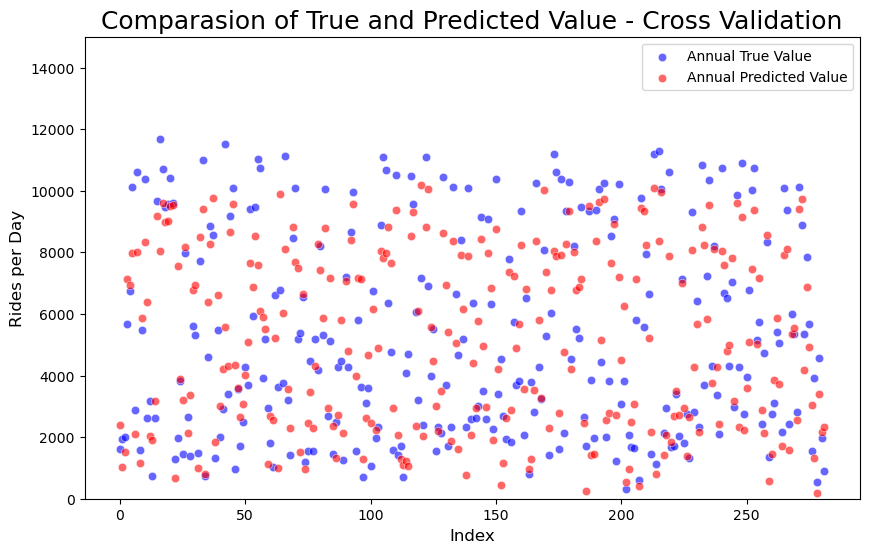

In [314]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = annual_data_cv, x = 'x_axis', y = 'true', color = 'b', label = 'Annual True Value', alpha = 0.6)
sns.scatterplot(data = annual_data_cv, x = 'x_axis', y = 'predicted', color = 'r', label = 'Annual Predicted Value', alpha = 0.6)
plt.ylim([0,15000])
plt.title('Comparasion of True and Predicted Value - Cross Validation', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [315]:
################Polynominal Regression for annual member#################

In [316]:
#Model 3: Polynominal regression with degree of 2 
from sklearn.preprocessing import PolynomialFeatures
  
poly_model_annual = PolynomialFeatures(degree = 2)
X_train_annual_poly = poly_model_annual.fit_transform(X_train_annual[selected_fea_annual])
linear_model_annual_poly = LinearRegression(fit_intercept = True)
linear_model_annual_poly.fit(X_train_annual_poly, y_train_annual)
y_fitted_annual_poly = linear_model_annual_poly.predict(X_train_annual_poly)

In [317]:
X_val_annual_poly = poly_model_annual.fit_transform(X_val_annual[selected_fea_annual])  
y_predicted_annual_poly = linear_model_annual_poly.predict(X_val_annual_poly)

In [318]:
training_error_annual_poly = rmse(y_train_annual, y_fitted_annual_poly)
training_mae_annual_poly = mean_absolute_error(y_train_annual, y_fitted_annual_poly)
r2_score_training_annual_poly = r2_score(y_train_annual, y_fitted_annual_poly)

print('Training RMSE: {}'.format(training_error_annual_poly))
print('Training MAE: {}'.format(training_mae_annual_poly))
print('Training R2 score: {}'.format(r2_score_training_annual_poly))

Training RMSE: num_annual    1134.648887
dtype: float64
Training MAE: 895.4219639157342
Training R2 score: 0.876222082565885


In [319]:
val_error_annual_poly = rmse(y_val_annual, y_predicted_annual_poly)
validation_mae_annual_poly = mean_absolute_error(y_val_annual, y_predicted_annual_poly)
r2_score_val_annual_poly = r2_score(y_val_annual, y_predicted_annual_poly)

print('Validation RMSE: {}'.format(val_error_annual_poly))
print('Validation MAE: {}'.format(validation_mae_annual_poly))
print('Validation R2 score: {}'.format(r2_score_val_annual_poly))

Validation RMSE: num_annual    2189.175952
dtype: float64
Validation MAE: 1651.461574393696
Validation R2 score: 0.5158079096267981


In [320]:
X_test_annual_poly = poly_model_annual.fit_transform(X_test_annual[selected_fea_annual])  
y_pred_test_annual_poly = linear_model_annual_poly.predict(X_test_annual_poly)

test_error_annual_poly = rmse(y_test_annual, y_pred_test_annual_poly)
test_mae_annual_poly = mean_absolute_error(y_test_annual, y_pred_test_annual_poly)
r2_score_test_annual_poly = r2_score(y_test_annual, y_pred_test_annual_poly)

print('Test RMSE: {}'.format(test_error_annual_poly))
print('Test MAE: {}'.format(test_mae_annual_poly))
print('Test R2 score: {}'.format(r2_score_test_annual_poly))

Test RMSE: num_annual    2190.230326
dtype: float64
Test MAE: 1772.5882953309808
Test R2 score: 0.594085803041609


In [321]:
x_axis_annual_poly = np.arange(len(y_test_annual))
annual_data_poly = pd.concat([pd.DataFrame(x_axis_annual_poly), y_test_annual.reset_index(), pd.DataFrame(y_pred_test_annual_poly)],axis =1, ignore_index = True)
annual_data_poly.columns = ['x_axis', 'index', 'true', 'predicted']

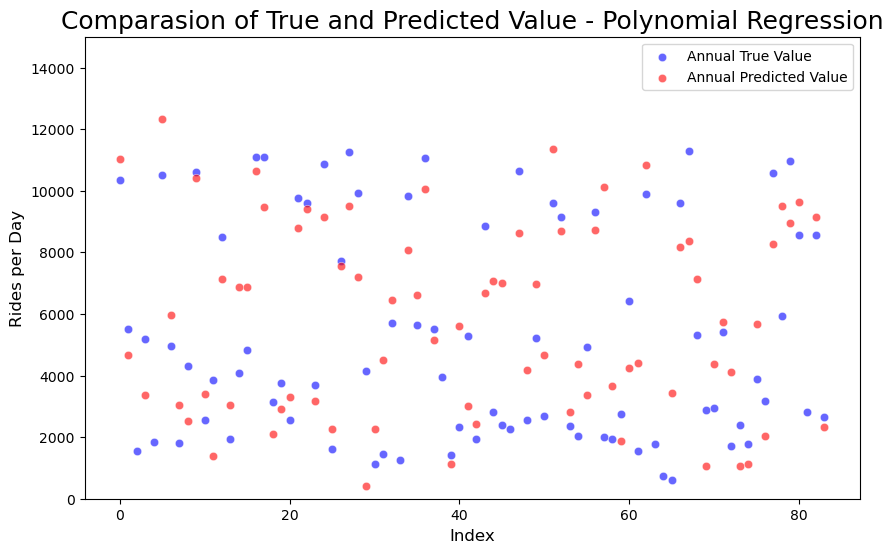

In [322]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = annual_data_poly, x = 'x_axis', y = 'true', color = 'b', label = 'Annual True Value', alpha = 0.6)
sns.scatterplot(data = annual_data_poly, x = 'x_axis', y = 'predicted', color = 'r', label = 'Annual Predicted Value', alpha = 0.6)
plt.ylim([0,15000])
plt.title('Comparasion of True and Predicted Value - Polynomial Regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [613]:
#########################Casual Member#############################

In [614]:
merged_casual = merged_final.drop(columns = ['annual_members'])
merged_casual['date'] = pd.to_datetime(merged_casual['date'])
merged_casual['date'] = merged_casual['date'].map(dt.datetime.toordinal)
merged_casual['date'] = merged_casual['date'].astype('float')

In [615]:
y_casual = pd.DataFrame(merged_casual['casual_members'].to_list(), 
                        index = merged_casual.index,
                        columns = ['num_casual'])
X_casual = merged_casual.drop(columns = ['casual_members'])

In [616]:
X_train_casual, X_test_val_casual, y_train_casual, y_test_val_casual = train_test_split(X_casual, y_casual, test_size = 0.3, random_state = 666)
X_test_casual, X_val_casual, y_test_casual, y_val_casual = train_test_split(X_test_val_casual, y_test_val_casual, test_size = 0.7, random_state = 333)

In [617]:
targets_casual = X_train_casual.columns

In [618]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude=['category'])),
        ('cat', OrdinalEncoder(), selector(dtype_include=['category']))],
        remainder='drop')
clf = RandomForestClassifier(random_state = 999, class_weight = 'balanced')
pipeline = Pipeline([('prep', column_trans),
                     ('clf', clf)])

pipeline.fit(X_train_casual, y_train_casual)
pipeline['clf'].feature_importances_

feat_list = []

In [884]:
total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets_casual, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets_casual, pipeline['clf'].feature_importances_):
    if feature[1] > .028:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))


 Cumulative Importance = 1.0
Most Important Features:
['seir_daily_unscaled_mean', 'inf_mean_unvax', 'daily_cases', 'pneumonia_mean', 'icu_beds_mean', 'admis_mean', 'admis_mean_unvax', 'infection_detection', 'temp', 'dew_temp', 'rh', 'wind_dir', 'wind_speed', 'press']
Number of Included Features = 14


In [885]:
selected_fea_casual = included_feats

In [886]:
linear_model_casual = LinearRegression(fit_intercept = True)
linear_model_casual.fit(X_train_casual[selected_fea_casual], y_train_casual)
y_fitted_casual = linear_model_casual.predict(X_train_casual[selected_fea_casual])
y_predicted_casual = linear_model_casual.predict(X_val_casual[selected_fea_casual])

In [887]:
training_error_casual = rmse(y_train_casual, y_fitted_casual)
training_mae_casual = mean_absolute_error(y_train_casual, y_fitted_casual)
r2_score_training_casual = r2_score(y_train_casual, y_fitted_casual)

print('Training RMSE: {}'.format(training_error_casual))
print('Training MAE: {}'.format(training_mae_casual))
print('Training r2 score: {}'.format(r2_score_training_casual))

Training RMSE: num_casual    2645.223009
dtype: float64
Training MAE: 1999.9497754223726
Training r2 score: 0.6271942910073443


In [888]:
val_error_casual = rmse(y_val_casual, y_predicted_casual)
val_mae_casual = mean_absolute_error(y_val_casual, y_predicted_casual)
r2_score_val_casual = r2_score(y_val_casual, y_predicted_casual)

print('Val RMSE: {}'.format(val_error_casual))
print('Val MAE: {}'.format(val_mae_casual))
print('Validation R2 score: {}'.format(r2_score_val_casual))

Val RMSE: num_casual    2821.059496
dtype: float64
Val MAE: 2215.7086785746915
Validation R2 score: 0.6178606510492575


In [889]:
# Prediction on test set
y_pred_test_casual = linear_model_casual.predict(X_test_casual[selected_fea_casual])

test_error_casual = rmse(y_test_casual, y_pred_test_casual)
test_mae_casual = mean_absolute_error(y_test_casual, y_pred_test_casual)
r2_score_test_casual = r2_score(y_test_casual, y_pred_test_casual)

print('Test RMSE: {}'.format(test_error_casual))
print('Test MAE: {}'.format(test_mae_casual))
print('Test R2 score: {}'.format(r2_score_test_casual)) 

Test RMSE: num_casual    2469.854679
dtype: float64
Test MAE: 1947.038773107642
Test R2 score: 0.5628946117633078


In [890]:
x_axis_casual = np.arange(len(y_test_casual))
casual_data = pd.concat([pd.DataFrame(x_axis_casual), y_test_casual.reset_index(), pd.DataFrame(y_pred_test_casual)],axis =1, ignore_index = True)
casual_data.columns = ['x_axis', 'index', 'true', 'predicted']

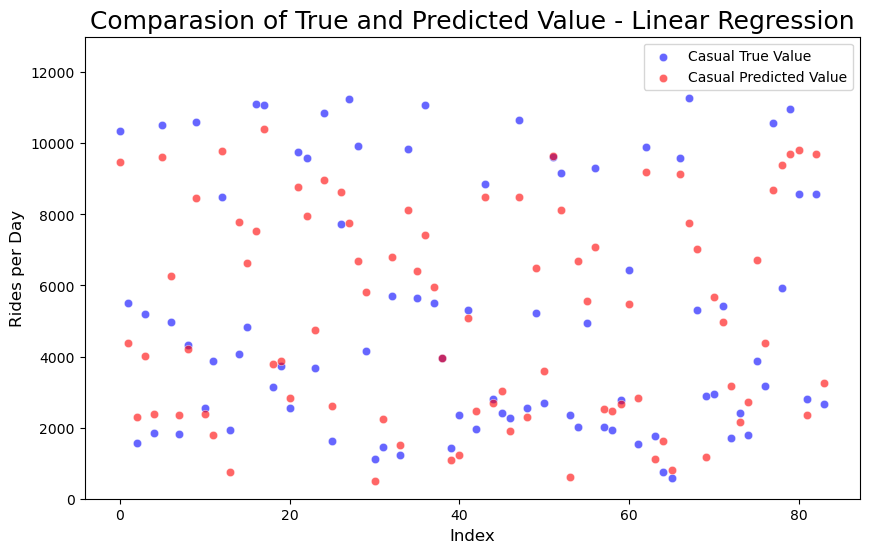

In [891]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = annual_data, x = 'x_axis', y = 'true', color = 'b', label = 'Casual True Value', alpha = 0.6)
sns.scatterplot(data = annual_data, x = 'x_axis', y = 'predicted', color = 'r', label = 'Casual Predicted Value', alpha = 0.6)
plt.ylim([0,13000])
plt.title('Comparasion of True and Predicted Value - Linear Regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [892]:
#####################Cross validation for casual data#######################

In [893]:
X_train_cv_casual, X_test_cv_casual, y_train_cv_casual, y_test_cv_casual  = train_test_split(X_casual, y_casual, test_size = 0.30, random_state = 999)

In [894]:
cv_scores_casual = cross_validate_rmse(model = LinearRegression(fit_intercept=True),
                                X = X_train_cv_casual, 
                                y = y_train_cv_casual,
                                selected_fea = selected_fea_casual)

In [895]:
linear_model_casual_cv = cv_scores_casual[6]

In [896]:
print('Train RMSE scores mean: {}'.format(np.mean(cv_scores_casual[0])))
print('Train MAE scores mean: {}'.format(np.mean(cv_scores_casual[2])))
print('Train r2 score mean: {}'.format(np.mean(cv_scores_casual[4])))

Train RMSE scores mean: 2510.587863635025
Train MAE scores mean: 1972.419848565475
Train r2 score mean: 0.6576921996492366


In [897]:
print('Val RMSE scores mean: {}'.format(np.mean(cv_scores_casual[1])))
print('Val MAE scores mean: {}'.format(np.mean(cv_scores_casual[3])))
print('Val r2 score mean: {}'.format(np.mean(cv_scores_casual[5])))

Val RMSE scores mean: 2561.626489393423
Val MAE scores mean: 2021.3243144318178
Val r2 score mean: 0.6386302759194097


In [898]:
y_pred_test_casual_cv = linear_model_casual_cv.predict(X_test_cv[selected_fea_casual])

test_error_casual_cv = rmse(y_test_cv_casual, y_pred_test_casual_cv)
test_mae_casual_cv = mean_absolute_error(y_test_cv_casual, y_pred_test_casual_cv)
r2_score_test_casual_cv = r2_score(y_test_cv_casual, y_pred_test_casual_cv)

print('Test RMSE: {}'.format(test_error_casual_cv))
print('Test MAE: {}'.format(test_mae_casual_cv))
print('Test R2 score: {}'.format(r2_score_test_casual_cv))

Test RMSE: num_casual    5823.826606
dtype: float64
Test MAE: 4478.921466202546
Test R2 score: -0.7103617986029684


In [899]:
x_axis_casual_cv = np.arange(len(y_test_cv_casual))
casual_data_cv = pd.concat([pd.DataFrame(x_axis_annual_cv), y_test_cv_casual.reset_index(), pd.DataFrame(y_pred_test_casual_cv)],axis =1, ignore_index = True)
casual_data_cv.columns = ['x_axis', 'index', 'true', 'predicted']

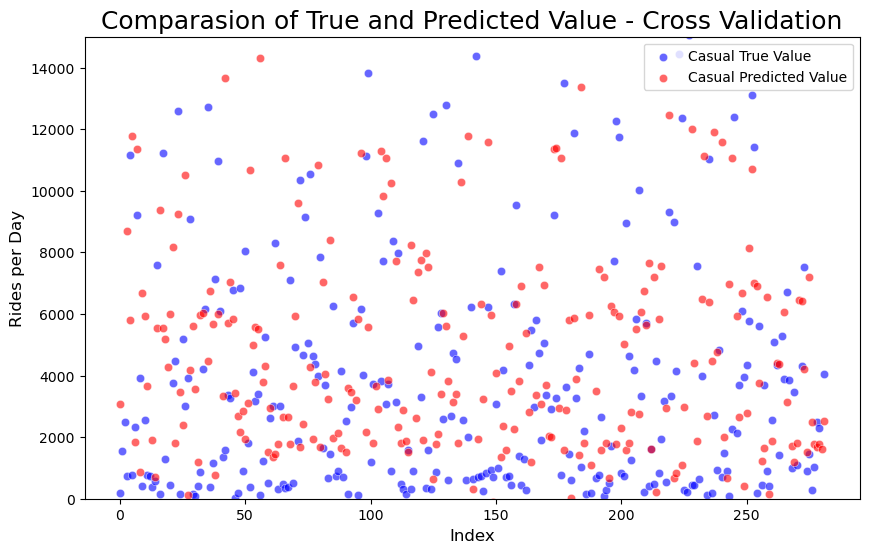

In [900]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = casual_data_cv, x = 'x_axis', y = 'true', color = 'b', label = 'Casual True Value', alpha = 0.6)
sns.scatterplot(data = casual_data_cv, x = 'x_axis', y = 'predicted', color = 'r', label = 'Casual Predicted Value', alpha = 0.6)
plt.ylim([0,15000])
plt.title('Comparasion of True and Predicted Value - Cross Validation', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [901]:
####################Poly regression for casual member###############

In [910]:
from sklearn.preprocessing import PolynomialFeatures
  
poly_model_casual = PolynomialFeatures(degree = 2)
X_train_casual_poly = poly_model_casual.fit_transform(X_train_casual[selected_fea_casual])
linear_model_casual_poly = LinearRegression(fit_intercept = True)
linear_model_casual_poly.fit(X_train_casual_poly, y_train_casual)
y_fitted_casual_poly = linear_model_casual_poly.predict(X_train_casual_poly)

In [911]:
X_val_casual_poly = poly_model_casual.fit_transform(X_val_casual[selected_fea_casual])  
y_predicted_casual_poly = linear_model_casual_poly.predict(X_val_casual_poly)

In [912]:
training_error_casual_poly = rmse(y_train_casual, y_fitted_casual_poly)
training_mae_casual_poly = mean_absolute_error(y_train_casual, y_fitted_casual_poly)
r2_score_training_casual_poly = r2_score(y_train_casual, y_fitted_casual_poly)

print('Training RMSE: {}'.format(training_error_casual_poly))
print('Training MAE: {}'.format(training_mae_casual_poly))
print('Training R2 score: {}'.format(r2_score_training_casual_poly))

Training RMSE: num_casual    1883.117895
dtype: float64
Training MAE: 1319.0398890767194
Training R2 score: 0.8110647502967169


In [914]:
val_error_casual_poly = rmse(y_val_casual, y_predicted_casual_poly)
val_mae_casual_poly = mean_absolute_error(y_val_casual, y_predicted_casual_poly)
r2_score_val_casual_poly = r2_score(y_val_casual, y_predicted_casual_poly)

print('Val RMSE: {}'.format(val_error_casual_poly))
print('Val MAE: {}'.format(val_mae_casual_poly))
print('Val R2 score: {}'.format(r2_score_val_casual_poly))

Val RMSE: num_casual    2475.52094
dtype: float64
Val MAE: 1808.2953969084756
Val R2 score: 0.7057405106657382


In [916]:
X_test_casual_poly = poly_model_casual.fit_transform(X_test_casual[selected_fea_casual])  
y_pred_test_casual_poly = linear_model_casual_poly.predict(X_test_casual_poly)

test_error_casual_poly = rmse(y_test_casual, y_pred_test_casual_poly)
test_mae_casual_poly = mean_absolute_error(y_test_casual, y_pred_test_casual_poly)
r2_score_test_casual_poly = r2_score(y_test_casual, y_pred_test_casual_poly)

print('Test RMSE: {}'.format(test_error_casual_poly))
print('Test MAE: {}'.format(test_mae_casual_poly))
print('Test R2 score: {}'.format(r2_score_test_casual_poly))

Test RMSE: num_casual    2139.449241
dtype: float64
Test MAE: 1531.0498158666305
Test R2 score: 0.6720200219252667


In [917]:
x_axis_casual_poly = np.arange(len(y_test_casual))
casual_data_poly = pd.concat([pd.DataFrame(x_axis_casual_poly), y_test_casual.reset_index(), pd.DataFrame(y_pred_test_casual_poly)],axis =1, ignore_index = True)
casual_data_poly.columns = ['x_axis', 'index', 'true', 'predicted']

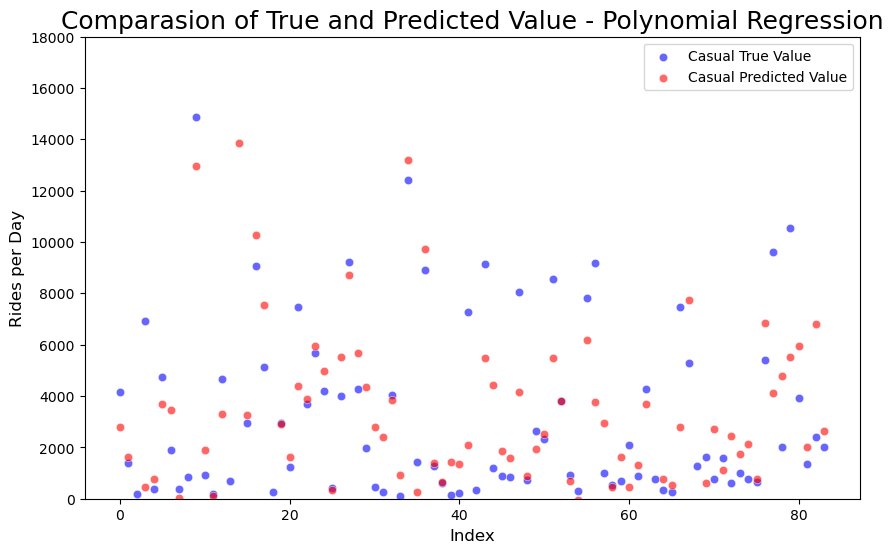

In [918]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = casual_data_poly, x = 'x_axis', y = 'true', color = 'b', label = 'Casual True Value', alpha = 0.6)
sns.scatterplot(data = casual_data_poly, x = 'x_axis', y = 'predicted', color = 'r', label = 'Casual Predicted Value', alpha = 0.6)
plt.ylim([0,18000])
plt.title('Comparasion of True and Predicted Value - Polynomial Regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()